# Transfer Learning on Cats-Dogs Classification - Fine Tune - Solution

### Fine-tune pre-trained CNN's top layers and classification layers to classify cats vs. dogs.

### Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### SDSC HPC-DS Summer Institute, UC San Diego

## Setup

In [1]:
import os
import random
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torchmetrics
from pytorch_lightning import callbacks as pl_callbacks
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from sklearn.metrics import classification_report
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision import datasets, models, transforms
# from torchsummary import summary
import torchvision

In [2]:
# Set global random seed for reproducibility

def set_seed(seed=1234):
    os.environ["PYTHONHASHSEED"] = str(0)  # disable hash randomization
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    pl.seed_everything(seed, workers=False)

set_seed()

[rank: 0] Seed set to 1234


In [3]:
!jupyter --version
print (pl.__version__)
print (torch.__version__)
!python --version

!nvidia-smi

Selected Jupyter core packages...
IPython          : 9.4.0
ipykernel        : 6.30.0
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.8.1
jupyter_server   : 2.16.0
jupyterlab       : 4.4.5
nbclient         : 0.10.2
nbconvert        : 7.16.6
nbformat         : 5.10.4
notebook         : not installed
qtconsole        : not installed
traitlets        : 5.14.3
2.5.2
2.5.1
Python 3.12.11
Tue Aug  5 15:32:32 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+================

In [4]:
from os.path import expanduser
HOME = expanduser("~")

DATA_DIR = HOME + "/data/catsVsDogs"
CHECKPOINT_DIR = "models/finetune"
NUM_CPUS = 4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(DEVICE)

cuda


In [6]:
IMAGE_DIM = 224
MEAN = (0.5, 0.5, 0.5)
STD = (0.5, 0.5, 0.5)
BATCH_SIZE = 16
LEARNING_RATE = 1e-5

## Define Transforms
Same transforms as in feature extraction, just in a different format

In [7]:
transform = {
    "train": transforms.Compose(
        [
            transforms.Resize(
                size=(IMAGE_DIM, IMAGE_DIM),
                interpolation=transforms.InterpolationMode.BILINEAR,
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
            transforms.RandomAffine(degrees=0, shear=0.2),  # Shear
            transforms.RandomResizedCrop(
                size=IMAGE_DIM,
                scale=(0.8, 1.2),
                interpolation=transforms.InterpolationMode.NEAREST,
            ),  # Zoom
            transforms.RandomHorizontalFlip(),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(
                size=(IMAGE_DIM, IMAGE_DIM),
                interpolation=transforms.InterpolationMode.BILINEAR,
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
        ]
    ),
}


## Define Data Module

In [8]:
class CatsDogsData(pl.LightningDataModule):
    def __init__(self, data_dir=DATA_DIR, batch_size=BATCH_SIZE):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform
        
    def prepare_data(self):
        self.train_data = datasets.ImageFolder(
            root=os.path.join(self.data_dir, "train"), transform=self.transform["train"]
        )
        self.val_data = datasets.ImageFolder(
            root=os.path.join(self.data_dir, "val"), transform=self.transform["val"]
        )
        self.test_data = datasets.ImageFolder(
            root=os.path.join(self.data_dir, "test"), transform=self.transform["val"]
        )
        
    def train_dataloader(self):
        """Train DataLoader."""
        # Num workers - speed up training
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=NUM_CPUS)

    def val_dataloader(self):
        """Validation DataLoader."""
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=NUM_CPUS)

    def test_dataloader(self):
        """Test DataLoader."""
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False, num_workers=NUM_CPUS)

## Define Model

In [9]:
class MobileNetV2Model(pl.LightningModule):
    """MobileNetV2 model class."""

    def __init__(self):
        super().__init__()
        self.automatic_optimization = (True)

        self.model = torch.hub.load(
            "pytorch/vision:v0.10.0", "mobilenet_v2", weights=torchvision.models.MobileNet_V2_Weights.DEFAULT, progress=False
        )
        
        self.accuracy = torchmetrics.Accuracy(task="binary").to(DEVICE)

        # Freeze weights up to layer 116
        for i, param in enumerate(self.model.parameters()):
            if i <= 116: param.requires_grad = False
            
        # Top model
        self.model.pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2), nn.Linear(1280, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.float())

    def configure_optimizers(self):
        opt = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()), lr=LEARNING_RATE
        )
        scheduler = LinearLR(opt, start_factor=0.5, total_iters=3)
        return [opt], [scheduler]

    def training_step(self, batch: int, batch_idx: int):
        """Training step."""
        X, y = batch
        logits = self(X.float()).view(-1)
        train_loss = F.binary_cross_entropy(logits, y.float())
        pred = logits >= 0.5
        train_acc = self.accuracy(pred, y)

        self.log("train_loss", train_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log("train_acc", train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return train_loss

    def validation_step(self, batch: int, batch_idx: int):
        """Validation step."""
        X, y = batch
        logits = self(X.float()).view(-1)
        valid_loss = F.binary_cross_entropy(logits, y.float())
        pred = logits >= 0.5
        valid_acc = self.accuracy(pred, y)

        self.log("val_loss", valid_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log("val_acc", valid_acc, prog_bar=True, on_epoch=True, on_step=False)
        return valid_loss

    def test_step(self, batch: int, batch_idx: int):
        """Test step."""
        X, y = batch
        logits = self(X.float()).view(-1)
        test_loss = F.binary_cross_entropy(logits, y.float())
        pred = logits >= 0.5
        test_acc = self.accuracy(pred, y)
        return test_loss


## Train Model

In [10]:
# Define max epochs
num_epochs = 30

# Define early stopping callback
early_stop = pl_callbacks.EarlyStopping(
    monitor="val_loss", patience=3, min_delta=1e-3, verbose=True, mode="min"
)

data = CatsDogsData()
data.prepare_data()


def get_predict(model, data_loader):
    """Get predictions from model and DataLoader."""
    true_values = []
    predicted_values = []
    for imgs, labels in data_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        true_values.extend(labels)
        predicted_values.extend((outputs >= 0.5).view(-1).cpu().numpy())

    return true_values, predicted_values


# Define model checkpoint callback
checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename=str(num_epochs) + "_{epoch:02d}-{step}",
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
    save_top_k=1,
    verbose = True,
)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=num_epochs,
    callbacks=[checkpoint, early_stop, TQDMProgressBar(refresh_rate=50)]
)

model_path = "models/feature_extraction/best_model.ckpt"
# Load from feature extraction checkpoint (rescale + augment)
model = MobileNetV2Model.load_from_checkpoint(
    checkpoint_path=model_path,
    strict=False,
)

# summarize model
model = model.to(DEVICE)
# summary(model, (3, 224, 224))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using cache found in /home/mhnguyen/.cache/torch/hub/pytorch_vision_v0.10.0


In [11]:
# Fit model and get best model path
trainer.fit(model, data)
best_model_path = checkpoint.best_model_path
print(f"Best model saved at: {best_model_path}")

/scratch/mhnguyen/job_41771574/ptl/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | model    | MobileNetV2    | 2.2 M  | train
1 | accuracy | BinaryAccuracy | 0      | train
----------------------------------------------------
1.7 M     Trainable params
542 K     Non-trainable params
2.2 M     Total params
8.901     Total estimated model params size (MB)
216       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 125/125 [00:02<00:00, 53.39it/s, v_num=4.18e+7]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 125/125 [00:02<00:00, 43.01it/s, v_num=4.18e+7, val_loss=0.171, val_acc=0.965, train_loss=0.231, train_acc=0.945]

Metric val_loss improved. New best score: 0.171
Epoch 0, global step 125: 'val_loss' reached 0.17127 (best 0.17127), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=00-step=125.ckpt' as top 1


Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 52.06it/s, v_num=4.18e+7, val_loss=0.171, val_acc=0.965, train_loss=0.231, train_acc=0.945]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 42.11it/s, v_num=4.18e+7, val_loss=0.153, val_acc=0.970, train_loss=0.222, train_acc=0.934]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.153
Epoch 1, global step 250: 'val_loss' reached 0.15334 (best 0.15334), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=01-step=250.ckpt' as top 1


Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 52.60it/s, v_num=4.18e+7, val_loss=0.153, val_acc=0.970, train_loss=0.222, train_acc=0.934]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 42.11it/s, v_num=4.18e+7, val_loss=0.127, val_acc=0.973, train_loss=0.184, train_acc=0.946]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.127
Epoch 2, global step 375: 'val_loss' reached 0.12713 (best 0.12713), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=02-step=375.ckpt' as top 1


Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 52.96it/s, v_num=4.18e+7, val_loss=0.127, val_acc=0.973, train_loss=0.184, train_acc=0.946]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 41.97it/s, v_num=4.18e+7, val_loss=0.116, val_acc=0.967, train_loss=0.164, train_acc=0.955]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.116
Epoch 3, global step 500: 'val_loss' reached 0.11575 (best 0.11575), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=03-step=500.ckpt' as top 1


Epoch 4: 100%|██████████| 125/125 [00:02<00:00, 52.35it/s, v_num=4.18e+7, val_loss=0.116, val_acc=0.967, train_loss=0.164, train_acc=0.955]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 125/125 [00:02<00:00, 42.10it/s, v_num=4.18e+7, val_loss=0.104, val_acc=0.970, train_loss=0.138, train_acc=0.964]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.104
Epoch 4, global step 625: 'val_loss' reached 0.10368 (best 0.10368), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=04-step=625.ckpt' as top 1


Epoch 5: 100%|██████████| 125/125 [00:02<00:00, 52.83it/s, v_num=4.18e+7, val_loss=0.104, val_acc=0.970, train_loss=0.138, train_acc=0.964]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 125/125 [00:02<00:00, 42.12it/s, v_num=4.18e+7, val_loss=0.0899, val_acc=0.973, train_loss=0.131, train_acc=0.961]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.090
Epoch 5, global step 750: 'val_loss' reached 0.08987 (best 0.08987), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=05-step=750.ckpt' as top 1


Epoch 6: 100%|██████████| 125/125 [00:02<00:00, 52.51it/s, v_num=4.18e+7, val_loss=0.0899, val_acc=0.973, train_loss=0.131, train_acc=0.961]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 125/125 [00:02<00:00, 42.43it/s, v_num=4.18e+7, val_loss=0.0874, val_acc=0.973, train_loss=0.122, train_acc=0.960]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.087
Epoch 6, global step 875: 'val_loss' reached 0.08736 (best 0.08736), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=06-step=875.ckpt' as top 1


Epoch 7: 100%|██████████| 125/125 [00:02<00:00, 51.21it/s, v_num=4.18e+7, val_loss=0.0874, val_acc=0.973, train_loss=0.122, train_acc=0.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 125/125 [00:02<00:00, 41.70it/s, v_num=4.18e+7, val_loss=0.0787, val_acc=0.978, train_loss=0.125, train_acc=0.951]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.079
Epoch 7, global step 1000: 'val_loss' reached 0.07867 (best 0.07867), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=07-step=1000.ckpt' as top 1


Epoch 8: 100%|██████████| 125/125 [00:02<00:00, 49.59it/s, v_num=4.18e+7, val_loss=0.0787, val_acc=0.978, train_loss=0.125, train_acc=0.951]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 125/125 [00:03<00:00, 40.38it/s, v_num=4.18e+7, val_loss=0.0735, val_acc=0.980, train_loss=0.093, train_acc=0.970]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.074
Epoch 8, global step 1125: 'val_loss' reached 0.07352 (best 0.07352), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=08-step=1125.ckpt' as top 1


Epoch 9: 100%|██████████| 125/125 [00:02<00:00, 50.65it/s, v_num=4.18e+7, val_loss=0.0735, val_acc=0.980, train_loss=0.093, train_acc=0.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 125/125 [00:03<00:00, 41.32it/s, v_num=4.18e+7, val_loss=0.0697, val_acc=0.978, train_loss=0.0924, train_acc=0.970]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.070
Epoch 9, global step 1250: 'val_loss' reached 0.06971 (best 0.06971), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=09-step=1250.ckpt' as top 1


Epoch 10: 100%|██████████| 125/125 [00:02<00:00, 52.48it/s, v_num=4.18e+7, val_loss=0.0697, val_acc=0.978, train_loss=0.0924, train_acc=0.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 125/125 [00:02<00:00, 41.98it/s, v_num=4.18e+7, val_loss=0.0703, val_acc=0.975, train_loss=0.0978, train_acc=0.965]

Epoch 10, global step 1375: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 125/125 [00:02<00:00, 53.18it/s, v_num=4.18e+7, val_loss=0.0703, val_acc=0.975, train_loss=0.0978, train_acc=0.965]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 125/125 [00:02<00:00, 42.97it/s, v_num=4.18e+7, val_loss=0.0639, val_acc=0.980, train_loss=0.0848, train_acc=0.970]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.064
Epoch 11, global step 1500: 'val_loss' reached 0.06392 (best 0.06392), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=11-step=1500.ckpt' as top 1


Epoch 12: 100%|██████████| 125/125 [00:02<00:00, 53.31it/s, v_num=4.18e+7, val_loss=0.0639, val_acc=0.980, train_loss=0.0848, train_acc=0.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 125/125 [00:02<00:00, 42.65it/s, v_num=4.18e+7, val_loss=0.0622, val_acc=0.978, train_loss=0.0853, train_acc=0.971]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.062
Epoch 12, global step 1625: 'val_loss' reached 0.06216 (best 0.06216), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=12-step=1625.ckpt' as top 1


Epoch 13: 100%|██████████| 125/125 [00:02<00:00, 53.41it/s, v_num=4.18e+7, val_loss=0.0622, val_acc=0.978, train_loss=0.0853, train_acc=0.971]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 125/125 [00:02<00:00, 43.07it/s, v_num=4.18e+7, val_loss=0.0615, val_acc=0.975, train_loss=0.083, train_acc=0.967] 

Epoch 13, global step 1750: 'val_loss' reached 0.06148 (best 0.06148), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=13-step=1750.ckpt' as top 1


Epoch 14: 100%|██████████| 125/125 [00:02<00:00, 51.78it/s, v_num=4.18e+7, val_loss=0.0615, val_acc=0.975, train_loss=0.083, train_acc=0.967]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 125/125 [00:03<00:00, 41.10it/s, v_num=4.18e+7, val_loss=0.0604, val_acc=0.980, train_loss=0.0703, train_acc=0.980]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.060
Epoch 14, global step 1875: 'val_loss' reached 0.06040 (best 0.06040), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=14-step=1875.ckpt' as top 1


Epoch 15: 100%|██████████| 125/125 [00:02<00:00, 53.26it/s, v_num=4.18e+7, val_loss=0.0604, val_acc=0.980, train_loss=0.0703, train_acc=0.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 125/125 [00:02<00:00, 43.39it/s, v_num=4.18e+7, val_loss=0.0586, val_acc=0.978, train_loss=0.0703, train_acc=0.978]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.059
Epoch 15, global step 2000: 'val_loss' reached 0.05857 (best 0.05857), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=15-step=2000.ckpt' as top 1


Epoch 16: 100%|██████████| 125/125 [00:02<00:00, 53.24it/s, v_num=4.18e+7, val_loss=0.0586, val_acc=0.978, train_loss=0.0703, train_acc=0.978]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 125/125 [00:02<00:00, 42.82it/s, v_num=4.18e+7, val_loss=0.0579, val_acc=0.980, train_loss=0.0697, train_acc=0.978]

Epoch 16, global step 2125: 'val_loss' reached 0.05785 (best 0.05785), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=16-step=2125.ckpt' as top 1


Epoch 17: 100%|██████████| 125/125 [00:02<00:00, 51.90it/s, v_num=4.18e+7, val_loss=0.0579, val_acc=0.980, train_loss=0.0697, train_acc=0.978]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 125/125 [00:02<00:00, 41.84it/s, v_num=4.18e+7, val_loss=0.0552, val_acc=0.980, train_loss=0.0793, train_acc=0.970]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.055
Epoch 17, global step 2250: 'val_loss' reached 0.05522 (best 0.05522), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=17-step=2250.ckpt' as top 1


Epoch 18: 100%|██████████| 125/125 [00:02<00:00, 51.76it/s, v_num=4.18e+7, val_loss=0.0552, val_acc=0.980, train_loss=0.0793, train_acc=0.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 125/125 [00:02<00:00, 42.09it/s, v_num=4.18e+7, val_loss=0.0578, val_acc=0.980, train_loss=0.0637, train_acc=0.975]

Epoch 18, global step 2375: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 125/125 [00:02<00:00, 52.15it/s, v_num=4.18e+7, val_loss=0.0578, val_acc=0.980, train_loss=0.0637, train_acc=0.975]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 125/125 [00:02<00:00, 42.07it/s, v_num=4.18e+7, val_loss=0.0537, val_acc=0.978, train_loss=0.0661, train_acc=0.976]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054
Epoch 19, global step 2500: 'val_loss' reached 0.05373 (best 0.05373), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=19-step=2500.ckpt' as top 1


Epoch 20: 100%|██████████| 125/125 [00:02<00:00, 52.64it/s, v_num=4.18e+7, val_loss=0.0537, val_acc=0.978, train_loss=0.0661, train_acc=0.976]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 125/125 [00:02<00:00, 42.75it/s, v_num=4.18e+7, val_loss=0.0535, val_acc=0.978, train_loss=0.0563, train_acc=0.980]

Epoch 20, global step 2625: 'val_loss' reached 0.05350 (best 0.05350), saving model to '/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=20-step=2625-v3.ckpt' as top 1


Epoch 21: 100%|██████████| 125/125 [00:02<00:00, 51.28it/s, v_num=4.18e+7, val_loss=0.0535, val_acc=0.978, train_loss=0.0563, train_acc=0.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 125/125 [00:02<00:00, 41.71it/s, v_num=4.18e+7, val_loss=0.0546, val_acc=0.978, train_loss=0.0461, train_acc=0.990]

Epoch 21, global step 2750: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 125/125 [00:02<00:00, 51.66it/s, v_num=4.18e+7, val_loss=0.0546, val_acc=0.978, train_loss=0.0461, train_acc=0.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 125/125 [00:03<00:00, 41.58it/s, v_num=4.18e+7, val_loss=0.058, val_acc=0.978, train_loss=0.0626, train_acc=0.976] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.054. Signaling Trainer to stop.
Epoch 22, global step 2875: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 125/125 [00:03<00:00, 40.65it/s, v_num=4.18e+7, val_loss=0.058, val_acc=0.978, train_loss=0.0626, train_acc=0.976]
Best model saved at: /home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=20-step=2625-v3.ckpt


## Evaluate Model

In [12]:
model = MobileNetV2Model.load_from_checkpoint(checkpoint_path=best_model_path)
model = model.to(DEVICE)
model.freeze()

# Make predictions
y_train, pred_train = get_predict(model, data.train_dataloader())
y_val, pred_val = get_predict(model, data.val_dataloader())
y_test, pred_test = get_predict(model, data.test_dataloader())

Using cache found in /home/mhnguyen/.cache/torch/hub/pytorch_vision_v0.10.0


In [13]:
print(checkpoint.best_model_path)

/home/mhnguyen/Teaching/SI2025/mhn-si/ptl/models/finetune/30_epoch=20-step=2625-v3.ckpt


In [14]:
print(f"Train:\n {classification_report(y_train, pred_train, digits=4)}")
print(f"Val:\n {classification_report(y_val, pred_val, digits=4)}")
print(f"Test:\n {classification_report(y_test, pred_test, digits=4)}")

Train:
               precision    recall  f1-score   support

           0     0.9980    0.9950    0.9965      1000
           1     0.9950    0.9980    0.9965      1000

    accuracy                         0.9965      2000
   macro avg     0.9965    0.9965    0.9965      2000
weighted avg     0.9965    0.9965    0.9965      2000

Val:
               precision    recall  f1-score   support

           0     0.9704    0.9850    0.9777       200
           1     0.9848    0.9700    0.9773       200

    accuracy                         0.9775       400
   macro avg     0.9776    0.9775    0.9775       400
weighted avg     0.9776    0.9775    0.9775       400

Test:
               precision    recall  f1-score   support

           0     0.9802    0.9900    0.9851       200
           1     0.9899    0.9800    0.9849       200

    accuracy                         0.9850       400
   macro avg     0.9850    0.9850    0.9850       400
weighted avg     0.9850    0.9850    0.9850       400

## Perform Inference

In [15]:
model = model.to(DEVICE)

In [16]:
# helper method to prepare image for model inference
def image_loader(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    image = transform(image).unsqueeze(0).to(DEVICE)
    return image

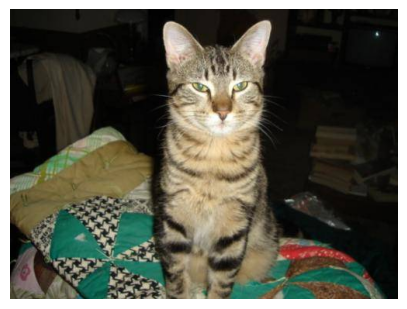


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1070.jpg: 
cat (0.0012)


In [17]:
image_path = DATA_DIR + "/test/cats/cat.1070.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

#Closer prediction is to 0, more confident it is a cat; close prediction is to 1, more confident it is a dog

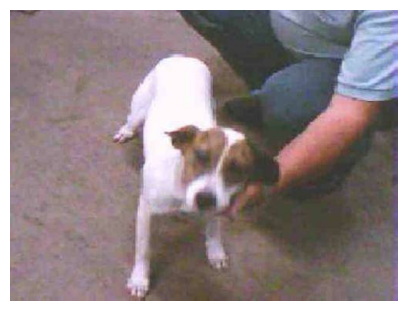


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1233.jpg: 
dog (0.9818)


In [18]:
image_path = DATA_DIR + "/test/dogs/dog.1233.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

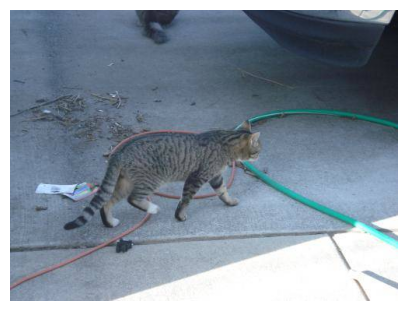


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1080.jpg: 
cat (0.1479)


In [19]:
image_path = DATA_DIR + "/test/cats/cat.1080.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

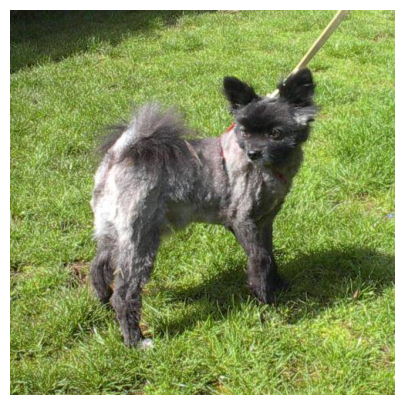


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1132.jpg: 
dog (0.9476)


In [20]:
image_path = DATA_DIR + "/test/dogs/dog.1132.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

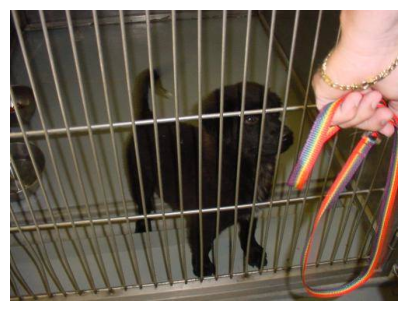


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1311.jpg: 
cat (0.2574)


In [21]:
image_path = DATA_DIR + "/test/dogs/dog.1311.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

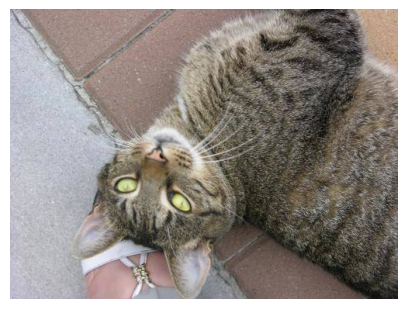


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1338.jpg: 
cat (0.0181)


In [22]:
image_path = DATA_DIR + "/test/cats/cat.1338.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

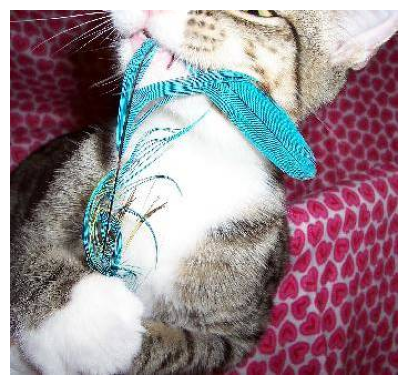


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1342.jpg: 
cat (0.0820)


In [23]:
image_path = DATA_DIR + "/test/cats/cat.1342.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

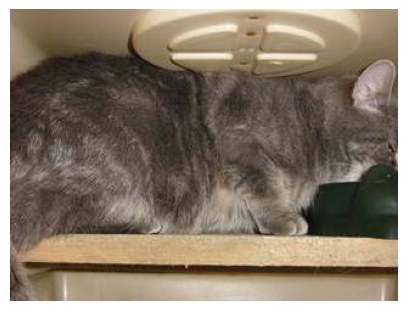


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1180.jpg: 
cat (0.0088)


In [24]:
image_path = DATA_DIR + "/test/cats/cat.1180.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

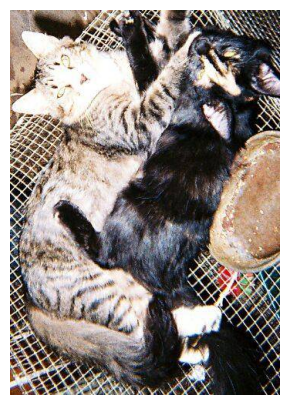


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1048.jpg: 
cat (0.2488)


In [25]:
image_path = DATA_DIR + "/test/cats/cat.1048.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

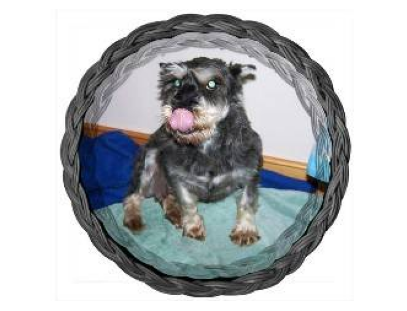


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1342.jpg: 
dog (0.6592)


In [26]:
image_path = DATA_DIR + "/test/dogs/dog.1342.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

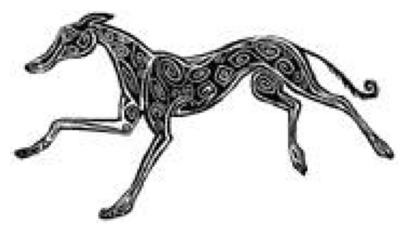


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1308.jpg: 
dog (0.6395)


In [27]:
image_path = DATA_DIR + "/test/dogs/dog.1308.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")